## Reference
[Growin API](https://honey-scraper-952.notion.site/Growin-Public-API-38decd3c089f40cdbadd5fb54bc4cd80)

##Packages
- yfinance (History stock price)
- request (API)
- pandas (Dataframe)
- json (Json)
- scikit-learn (Machine Learning)
- numpy (standard deviation)
- Matplotlib (Line Chart)


In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install Matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Implement

API

In [5]:
import json
import pandas as pd
import requests

start_end = ['2016-01-01', '2022-09-30']
api_key = 'tv-ffb6c7b0-b70d-480f-b074-e3290cc29287'
url_head = 'https://api.tradingvalley.com/public'
api_url = {
    'symbol_rating': lambda oriented, symbol: f'{url_head}/historical/rating/{oriented}/{symbol}?start_at={start_end[0]}&end_at={start_end[1]}',
    'symbol_indicators': lambda oriented, symbol, indicator: f'{url_head}/historical/{oriented}/{symbol}/{indicator}?start_at={start_end[0]}&end_at={start_end[1]}',
    'vix': f'{url_head}/historical/stock/vix?start_at={start_end[0]}&end_at={start_end[1]}'
}
company='KO'

History stock price

In [6]:
import yfinance
data = yfinance.download([company], start=start_end[0], end='2022-10-01')
data['T'] = data['Close'] > data['Open']
data['Q'] = (data['Close'] - data['Open']) / data['Open']
quote = data[data.columns[[7]]].reset_index(drop=True)
data = data[data.columns[[6]]].reset_index(drop=True)
#data

[*********************100%***********************]  1 of 1 completed


分析指標-五力評分中的趨勢(trend) 與 VIX 指數

In [7]:
session = requests.Session()
session.headers.update({'X-API-KEY': api_key})

url_trend = api_url['symbol_rating']('trend', company)
print(f'call {url_trend}')
response = session.get(url_trend)
trend = pd.DataFrame(json.loads(response.text)['data'][::-1]).set_index('date', drop=True)
trend['s1'] = trend['score'].shift(1, fill_value=0)
trend['s2'] = trend['score'].shift(2, fill_value=0)

url_vix = api_url['vix']
print(f'call {url_vix}')
response = session.get(url_vix)
vix = pd.DataFrame(json.loads(response.text)['data'][::-1]).set_index('date', drop=True)

url_st = api_url['symbol_indicators']('trend', 'AAPL', 'surfing-trend')
print(f'call {url_st}')
response = session.get(url_st)
st = pd.DataFrame(json.loads(response.text)['data'][::-1]).set_index('date', drop=True)

call https://api.tradingvalley.com/public/historical/rating/trend/KO?start_at=2016-01-01&end_at=2022-09-30
call https://api.tradingvalley.com/public/historical/stock/vix?start_at=2016-01-01&end_at=2022-09-30
call https://api.tradingvalley.com/public/historical/trend/AAPL/surfing-trend?start_at=2016-01-01&end_at=2022-09-30


Combine

In [8]:
df = pd.concat([vix, trend], join='inner', axis=1, sort=False).reset_index(drop=True)
df = pd.concat([df, data], axis=1, sort=False)
df.columns = ['VIX', 'S0', 'S1', 'S2', 'T']
#df

Split data

In [9]:
# Test size = 188 (start='2022-01-01', end='2022-09-30')
X = df.drop(columns=['T']).values
y = df['T'].values
idx = len(y)-188
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]
q0 = quote.values[:idx]
q1 = quote.values[idx:]

Machine Learning Model (use support vector classifier) with evaluation by precision_score, recall_score, f1_score

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('svc', SVC(kernel='linear', random_state=0))])
model = pipe.fit(X_train, y_train)

#prediction
from sklearn.metrics import precision_score, recall_score, f1_score
print('Train data: ')
y_pred0 = model.predict(X_train)
print(f'precision_score: {precision_score(y_train, y_pred0):.6f}')
print(f'recall_score: {recall_score(y_train, y_pred0):.6f}')
print(f'f1_score: {f1_score(y_train, y_pred0):.6f}')
print('-'*30)
print('Test data: ')
y_pred1 = model.predict(X_test)
print(f'precision_score: {precision_score(y_test, y_pred1):.6f}')
print(f'recall_score: {recall_score(y_test, y_pred1):.6f}')
print(f'f1_score: {f1_score(y_test, y_pred1):.6f}')

Train data: 
precision_score: 0.573869
recall_score: 0.733933
f1_score: 0.644106
------------------------------
Test data: 
precision_score: 0.598291
recall_score: 0.666667
f1_score: 0.630631


##Performance

Train data with return rate and sharpe ratio

In [11]:
# train data's performance
import numpy as np
q = q0
y_pred = y_pred0
asset = 100000
price = 100000
asset_change = [asset]
price_change = [price]
volatility = []
risk_free = 0.01/100

for i, v in enumerate(y_pred):
  if v: asset *= float(1 + q[i])
  else: asset *= 1
  price *= float(1 + q[i])
  volatility.append(float(v*q[i]))
  asset_change.append(float(asset))
  price_change.append(float(price))

std = np.std(np.array(volatility))
period = len(y_pred)
return_rate = float((asset-100000)/100000/period)
price_rate = float((price-100000)/100000/period)
print('Train data - \nWith classifier: ')
print(f'獲利: ${int(asset-100000)}')
print(f'總報酬率(%): {(asset-100000)/100000*100:.6f}')
print(f'年化報酬率(%): {((1+return_rate)**365-1)*100:.6f}')
print(f'日平均報酬率(%): {return_rate*100:.6f}')
print(f'Sharpe Ratio: {(return_rate-risk_free)/std*(252**0.5):.6f}')
print('-'*30)
print('Without classifier: ')
print(f'總報酬率(%): {(price-100000)/100000*100:.6f}')
print(f'年化報酬率(%): {((1+price_rate)**365-1)*100:.6f}')
print(f'日平均報酬率(%): {price_rate*100:.6f}')

Train data - 
With classifier: 
獲利: $185393
總報酬率(%): 185.393440
年化報酬率(%): 56.449856
日平均報酬率(%): 0.122696
Sharpe Ratio: 3.035256
------------------------------
Without classifier: 
總報酬率(%): -8.891332
年化報酬率(%): -2.124968
日平均報酬率(%): -0.005884


asset change chart

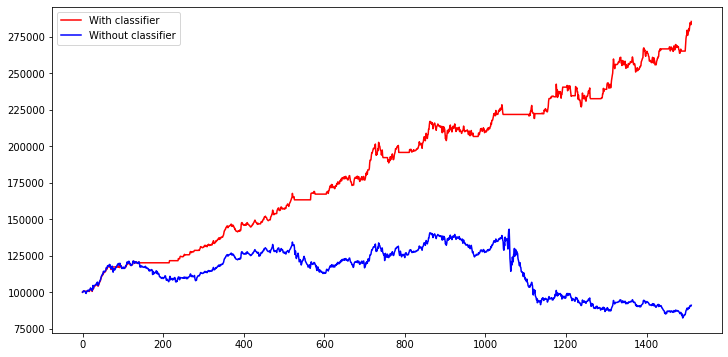

In [12]:
import matplotlib.pyplot as plt
x1 = [i for i in range(len(asset_change))]
y1 = asset_change
y2 = price_change
plt.figure(figsize=(12,6))
plt.plot(x1, y1, color='red', ms=1, label='With classifier')
plt.plot(x1, y2, color='blue', ms=1, label='Without classifier')
plt.legend()
plt.show()

Test data with return rate and sharpe ratio

In [13]:
# test data's performance
import numpy as np
q = q1
y_pred = y_pred1
asset = 100000
price = 100000
asset_change = [asset]
price_change = [price]
volatility = []
risk_free = 0.01/100

for i, v in enumerate(y_pred):
  if v: asset *= float(1 + q[i])
  price *= float(1 + q[i])
  volatility.append(float(v*q[i]))
  asset_change.append(float(asset))
  price_change.append(float(price))

std = np.std(np.array(volatility))
period = len(y_pred)
return_rate = float((asset-100000)/100000/period)
price_rate = float((price-100000)/100000/period)
print('Test data - \nWith classifier: ')
print(f'獲利: ${int(asset-100000)}')
print(f'總報酬率(%): {(asset-100000)/100000*100:.6f}')
print(f'年化報酬率(%): {((1+return_rate)**365-1)*100:.6f}')
print(f'日平均報酬率(%): {return_rate*100:.6f}')
print(f'Sharpe Ratio: {(return_rate-risk_free)/std*(252**0.5):.6f}')
print('-'*30)
print('Without classifier: ')
print(f'總報酬率(%): {(price-100000)/100000*100:.6f}')
print(f'年化報酬率(%): {((1+price_rate)**365-1)*100:.6f}')
print(f'日平均報酬率(%): {price_rate*100:.6f}')

Test data - 
With classifier: 
獲利: $27351
總報酬率(%): 27.351226
年化報酬率(%): 70.001187
日平均報酬率(%): 0.145485
Sharpe Ratio: 2.676116
------------------------------
Without classifier: 
總報酬率(%): 0.293593
年化報酬率(%): 0.571631
日平均報酬率(%): 0.001562


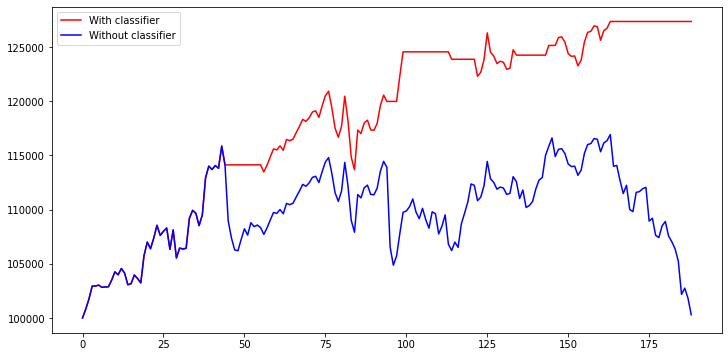

In [14]:
import matplotlib.pyplot as plt
x1 = [i for i in range(len(asset_change))]
y1 = asset_change
y2 = price_change
plt.figure(figsize=(12,6))
plt.plot(x1, y1, color='red', ms=5, label='With classifier')
plt.plot(x1, y2, color='blue', ms=5, label='Without classifier')
plt.legend()
plt.show()